# Вариационные автокодировщики

## Постановка задачи
Даны выборка независимых одинаково распределенных величин из истинного распределения $x_i \sim p_d(x)$, $i = 1, \dots, N$.

Задача - построить вероятностную модель $p_\theta(x)$ истинного распределения $p_d(x)$.

$p_\theta(x)$ должно позволять как оценить плотность вероятности для данного объекта $x$, так и сэмплировать $x \sim p_\theta(x)$.

## Вероятностная модель
$z \in \mathbb{R}^d$ - локальная латентная переменная, т. е. своя для каждого объекта $x$.

Генеративный процесс Вариационного автокодировщика:
1. Сэмплируем $z \sim p(z)$.
2. Сэмплируем $x \sim p_\theta(x | z)$.

Параметры распределения $p_\theta(x | z)$ задаются нейросетью с весами $\theta$, получающей на вход вектор $z$.

Индуцированная генеративным процессом плотность вероятности объекта $x$:

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} p_\theta(x | z)$$

Эта плотность может быть оценена с помощью метода Монте-Карло:

$$z_i \sim p(z), i = 1, \dots, K$$
$$p_\theta(x) \approx \frac{1}{K} \sum\limits_{i = 1}^K p_\theta(x | z_i)$$

### Параметризация модели
Априорное распределение на скрытые перменные - стандартное нормальное: $p(z) = \mathcal{N}(z | 0, I)$.

Распределения на компоненты $x$ условно независимы относительно $z$: $p_\theta(x | z) = \prod\limits_{i = 1}^D p_\theta(x_i | z)$.

Если i-ый признак объекта вещественны, то $p_\theta(x_i | z) = \mathcal{N}(x_i | \mu_i(z, \theta), \sigma^2_i(z, \theta))$.
Здесь $\mu(z, \theta)$ и $\sigma(z, \theta)$ - детерминированные функции, задаваемые нейросетями с параметрами $\theta$. deterministic functions defined by neural networks with parameters $\theta$.

Если i-ый признак категориальный, то $p_\theta(x_i | z) = Cat(Softmax(\omega_i(z, \theta)))$, где $\omega_i(z, \theta)$ is тоже детерминированная функция задаваемая нейросетью.

## Обучение модели с использованием принципа максимального правдоподобия

Описанная модель может быть обучена с помощью максимизации правдоподобия модели методом стохастического градиентного спуска. Правдоподобие и его градиент не могут быть вычислены в явном виде, поэтому вместо них используем их оценки, полученные методом Монте-Карло:

$$\log p_\theta(x) =
\log \mathbb{E}_{z \sim p(z)} p_\theta(x | z)
\approx \log \frac{1}{K} \sum\limits_{i=1}^K p_\theta(x | z_i)$$
$$\log p_\theta(x) \to \max\limits_\theta$$
$$\frac{\partial \log p_\theta(x)}{\partial \theta} =
\frac{\partial}{\partial \theta} \log \mathbb{E}_{z \sim p(z)} p_\theta(x | z)
\approx \frac{\partial}{\partial \theta} \log \frac{1}{K} \sum\limits_{i=1}^K p_\theta(x | z_i)$$

Кстати, докажите несмещенность оценки на градиент.

Ваше доказательство здесь.


$$\frac{\partial \log p_\theta(x)}{\partial \theta} =
\frac{\partial}{\partial \theta} \log \mathbb{E}_{z \sim p(z)} p_\theta(x | z) =
\int p_\theta(x | z)p(z)\partial \theta
\approx \frac{\partial}{\partial \theta} \log \frac{1}{K} \sum\limits_{i=1}^K p_\theta(x | z_i)$$

### Загрузка, нормировка и визуалиация данных

In [1]:
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable

In [2]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)

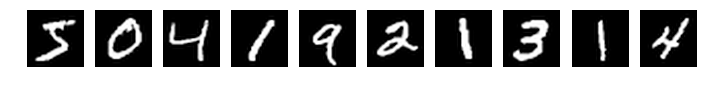

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, 28, 28)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

show_images(Variable(train_data[:10][0]))

### Функция потерь: кроссэнтропия

В качестве функции потерь используем бинарную кроссэнтропию.
Это означает, что мы предполагаем, что каждый пискель - бинарная случайная величина.
Генеративная сеть выдает вероятность каждого пикселя быть равным $1$.
Однако это означает, что для корректности вероятностной модели исходное изображение также должно быть бинаризовано.

Бинаризация может провоиться как округлением данных в датасете, так и сэмплингом из распределения Бернулли каждого пикселя. Округление приводит к более гладким фигурам в обучающей выборке, поэтому будет использовать его.

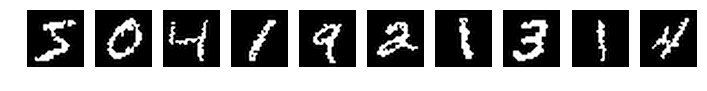

In [4]:
show_images(Variable(torch.bernoulli(train_data[:10][0])))

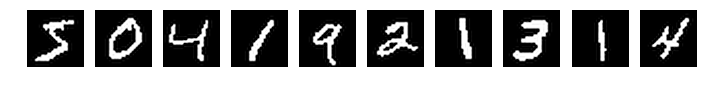

In [5]:
show_images(Variable(train_data[:10][0].round()))

In [6]:
train_data.data_tensor = train_data.data_tensor.round()
test_data.data_tensor = test_data.data_tensor.round()

In [7]:
def binary_crossentropy_loss(x_true, x_distr):
    """
    Вычисляет бинарную кроссэнтропию между эмприческим распределением на данные
    и индуцированным моделью распределением, т. е. правдоподобие объектов x_true.
    Каждому объекту из x_true соответствуют K сэмплированных распределений
    на x из x_distr.
    i-му объекту соответствуют распределения с номерами i * K, ..., (i + 1) * K - 1.
    Требуется вычислить оценку логарифма правдоподобия для каждого объекта.
    Подсказка: не забывайте про вычислительную стабильность!

    Вход: x_true, Variable - матрица объектов размера n x D.
    Вход: x_distr, Variable - матрица параметров распределений Бернулли
    размера (n * K) x D.
    Выход: Variable, матрица размера n x K - оценки логарифма правдоподобия
    каждого сэмпла.
    """
    K = x_distr.shape[0] // x_true.shape[0]
    n, D = x_true.shape
    # ваш код здесь 
    x_true = x_true.view(1, n, D).permute(1,0,2)
    x_distr = x_distr.clamp(1e-10, 1-1e-10)
    one = Variable(torch.FloatTensor([1]))
    loglikelihood = (x_true * x_distr.log() + (one - x_true) * (one - x_distr).log()).sum(dim=2)
#     print('DEBUG:', x_distr.min(), x_distr.max())
    return loglikelihood

In [8]:
def log_mean_exp(mtx):
    """
    Возвращает логарифм среднего по каждому столбцу от экспоненты данной матрицы.
    Подсказка: не забывайте про вычислительную стабильность!
    Вход: mtx, Varibale - матрица размера n x k.
    Возвращаемое значение: Variable, вектор длины n.
    """
    # ваш код здесь
    n, k = mtx.shape
    mtx_max = mtx.max(dim=1)[0]
    mtx = mtx - mtx_max.view(n, 1)
    return mtx.exp().mean(dim=1).log() + mtx_max


### Модель

In [9]:
class NaiveModel(nn.Module):
    def __init__(self, d, D):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D = D
        self.generative_network = nn.Sequential(
            nn.Linear(self.d, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.D),
            nn.Sigmoid()
        )

    def sample_prior(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        # ваш код здесь
        z = Variable(torch.randn((num_samples, self.d)))
        return z

    def generative_distr(self, z):
        """
        По матрице латентных представлений z возвращает матрицу параметров
        распределения Бернулли для сэмплирования объектов x.
        Вход: z, Variable - матрица n x d латентных представлений.
        Возвращаемое значение: Variable, матрица параметров распределения
        Бернулли размера n x D.
        """
        # ваш код здесь
        distr = self.generative_network(z)
        return distr
        

    def batch_loss(self, batch, K):
        """
        Вычисляет оценку логарифма правдоподобия по батчу используя K сэмплов
        для каждого объекта.
        Вход: batch, Variable - матрица объектоа размера n x D.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, скаляр - логарифм правдоподобия по батчу.
        """
        # ваш код здесь
        n, _ = batch.shape
        batch = batch
        z = self.sample_prior(n * K)
        distr = self.generative_distr(z)
        return log_mean_exp(binary_crossentropy_loss(batch, distr)).mean()

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        z = self.sample_prior(num_samples)
        distr = self.generative_distr(z)
        samples = torch.bernoulli(distr)
        return samples
        

In [10]:
def model_test_loss(compute_loss, batch_size=100, max_batches=None, verbose=False):
    """
    Функция вычисляет усредненное значение функции потерь по тестовым данным.
    Вход: compute_loss, функция, принимающая батч в виде матрицы torch.FloatTensor
    и возвращающая float - функцию потерь на батче.
    Вход: batch_size, int.
    Вход: max_batches, int - если задано, включает режим оценки функции потерь
    с помощью сэмплирования батчей вместо полного прохода по данным и указывает,
    после какого батча прекратить вычисления.
    Вход: verbose, bool - указывает, печатать ли текущее состояние в процессе работы.
    Возвращаемое значение: float - оценка функции потерь на тестовых данных.
    """
    dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=(max_batches is None))
    num_batches = len(dataloader)
    avg_loss = 0
    for i, (batch, _) in enumerate(dataloader):
        loss = compute_loss(Variable(batch))
        avg_loss += (loss - avg_loss) / (i + 1)
        if verbose and (i + 1) % 10 == 0:
            print('\rTest loss:', avg_loss,
                  'Batch', i + 1, 'of', num_batches, ' ' * 10, end='', flush=True)
        if verbose and (i + 1) % 100 == 0:
            print(flush=True)
        if max_batches and i >= max_batches:
            break
    return avg_loss

In [11]:
def compute_log_likelihood_monte_carlo(batch, model, K):
    """
    Функция, оценку логарифма правдоподобия вероятностной модели по батчу методом Монте-Карло.
    Вход: batch, FloatTensor - матрица размера n x D
    Вход: model, Module - объект, имеющий методы sample_prior и generative_distr, описанные в NaiveModel.
    Вход: K, int - количество сэмплов.
    Возвращаемое значение: float - оценка логарифма правдоподобия.
    """
    # ваш код здесь
    return model.batch_loss(batch, K).data.numpy()

def model_test_log_likelihood_monte_carlo(model, K=10, batch_size=100, max_batches=None, verbose=False):
    """
    Функция, вовращает оценку логарифма правдоподобия данной модели по тестовым данным.
    Вход: model, Module - объект, имеющий методы sample_prior и generative_distr, описанные в NaiveModel.
    Вход: K, int - количество сэмплов.
    Остальные входы описаны в функции model_test_loss.
    Возвращаемое значение: float - оценка логарифма правдоподобия.    
    """
    return model_test_loss(lambda batch: compute_log_likelihood_monte_carlo(batch, model, K),
                           batch_size=batch_size,
                           max_batches=max_batches,
                           verbose=verbose)

In [12]:
def train_model(model, tests=[], batch_size=100, K=1, num_epochs=3, learning_rate=1e-3):
    """
    Обучает модель.
    Вход: model, Module - объект, модель.
    У этого объекта должна быть функция batch_loss от batch - FloatTensor и K - int,
    возвращающая скаляр Variable - функцию потерь на батче, которая должна быть
    оптимизирована.
    Вход: tests - список тестов, выполняемых после каждого 100-го батча.
    Каждый элемент списка - словарь с полями 'name' - уникальным идентификатором
    теста и 'func' - функцией от модели.
    Вход: batch_size, int.
    Вход: K, int.
    Вход: num_epochs, int.
    Вход: learning_rate, float.
    Возвращаемое значение: словарь с полями 'model' - обученная модель,
    'train_losses_list' - список функций потерь на каждом батче и 
    'test_results' - список результатов тестирования. Каждый результат
    тестирования - словарь вида name: value, где name - имя теста,
    value - результат его выполнения.
    """
    gd = optim.Adam(model.parameters(), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(dataloader):
            total = len(dataloader)
            loss = model.batch_loss(Variable(batch), K)
            (-loss).backward()
            train_losses.append(loss.data.numpy()[0])
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            if (i + 1) % 100 == 0:
                cur_test_result = {}
                for test in tests:
                    cur_test_result[test['name']] = test['func'](model)
                test_results.append(cur_test_result)
                print(flush=True)
            gd.step()
            gd.zero_grad()
    return {
        'model': model,
        'train_losses_list': train_losses,
        'test_results': test_results
    }

In [13]:
naive_tests = [
    {
        'name': 'MC',
        'func': lambda model: model_test_log_likelihood_monte_carlo(model, max_batches=20)
    }
]

In [78]:
naive_model_d2_k1 = train_model(NaiveModel(2, 784), tests=naive_tests, K=1)
# show_images(naive_model_d2_k1['model'].generate_samples(10))
# draw_manifold(naive_model_d2_k1['model'])
# del naive_model_d2_k1

Train loss: -185.438 Batch 100 of 600           
Train loss: -163.044 Batch 200 of 600           
Train loss: -169.541 Batch 300 of 600           
Train loss: -160.501 Batch 400 of 600           
Train loss: -154.072 Batch 500 of 600           
Train loss: -161.818 Batch 600 of 600           
Train loss: -157.972 Batch 100 of 600           
Train loss: -156.284 Batch 200 of 600           
Train loss: -156.609 Batch 300 of 600           
Train loss: -161.472 Batch 400 of 600           
Train loss: -154.818 Batch 500 of 600           
Train loss: -152.947 Batch 600 of 600           
Train loss: -153.49 Batch 100 of 600           
Train loss: -151.006 Batch 200 of 600           
Train loss: -158.371 Batch 300 of 600           
Train loss: -149.832 Batch 400 of 600           
Train loss: -157.589 Batch 500 of 600           
Train loss: -150.213 Batch 600 of 600           


In [79]:
naive_model_d2_k10 = train_model(NaiveModel(2, 784), tests=naive_tests, K=10)
# show_images(naive_model_d2_k10['model'].generate_samples(10))
# draw_manifold(naive_model_d2_k10['model'])
# del naive_model_d2_k10

Train loss: -178.492 Batch 100 of 600           
Train loss: -177.132 Batch 200 of 600           
Train loss: -170.235 Batch 300 of 600           
Train loss: -157.01 Batch 400 of 600            
Train loss: -168.407 Batch 500 of 600           
Train loss: -156.023 Batch 600 of 600           
Train loss: -154.392 Batch 100 of 600           
Train loss: -156.926 Batch 200 of 600           
Train loss: -150.211 Batch 300 of 600           
Train loss: -157.156 Batch 400 of 600           
Train loss: -149.191 Batch 500 of 600           
Train loss: -154.639 Batch 600 of 600           
Train loss: -151.139 Batch 100 of 600           
Train loss: -143.847 Batch 200 of 600           
Train loss: -137.562 Batch 300 of 600           
Train loss: -143.82 Batch 400 of 600            
Train loss: -135.589 Batch 500 of 600           
Train loss: -142.566 Batch 600 of 600           


In [ ]:
naive_model_d10_k1 = train_model(NaiveModel(10, 784), tests=naive_tests, K=1)
# show_images(naive_model_d10_k1['model'].generate_samples(10))
# del naive_model_d10_k1

Train loss: -177.267 Batch 100 of 600           
Train loss: -165.143 Batch 200 of 600           
Train loss: -161.352 Batch 300 of 600           
Train loss: -150.802 Batch 400 of 600           
Train loss: -150.225 Batch 500 of 600           
Train loss: -153.304 Batch 600 of 600           
Train loss: -154.937 Batch 100 of 600           
Train loss: -158.278 Batch 200 of 600           
Train loss: -154.685 Batch 300 of 600           
Train loss: -146.045 Batch 400 of 600           
Train loss: -150.494 Batch 500 of 600           
Train loss: -146.82 Batch 600 of 600            
Train loss: -153.725 Batch 100 of 600           
Train loss: -151.138 Batch 200 of 600           
Train loss: -147.409 Batch 300 of 600           
Train loss: -154.974 Batch 400 of 600           
Train loss: -151.005 Batch 500 of 600           
Train loss: -139.666 Batch 600 of 600           


In [ ]:
naive_model_d10_k10 = train_model(NaiveModel(10, 784), tests=naive_tests, K=10)
# show_images(naive_model_d10_k10['model'].generate_samples(10))
# del naive_model_d10_k10

Train loss: -170.71 Batch 100 of 600           
Train loss: -154.716 Batch 200 of 600           
Train loss: -150.896 Batch 300 of 600           
Train loss: -133.987 Batch 300 of 600           
Train loss: -129.268 Batch 400 of 600           
Train loss: -120.942 Batch 500 of 600           
Train loss: -135.435 Batch 600 of 600           
Train loss: -133.356 Batch 100 of 600           
Train loss: -148.715 Batch 200 of 600           
Train loss: -132.763 Batch 300 of 600           
Train loss: -128.88 Batch 400 of 600            
Train loss: -129.64 Batch 500 of 600            
Train loss: -128.226 Batch 600 of 600           


## Оценка качества модели

### Визуальная оценка генерируемых объектов

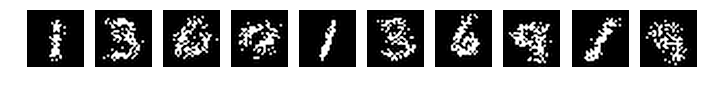

In [82]:
show_images(naive_model_d2_k1['model'].generate_samples(10))

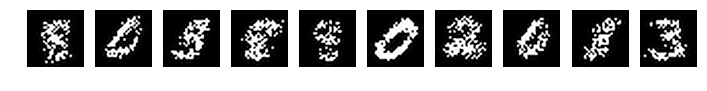

In [83]:
show_images(naive_model_d2_k10['model'].generate_samples(10))

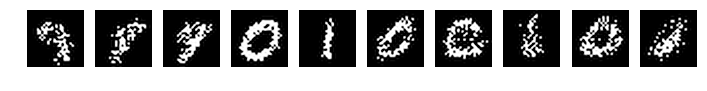

In [84]:
show_images(naive_model_d10_k1['model'].generate_samples(10))

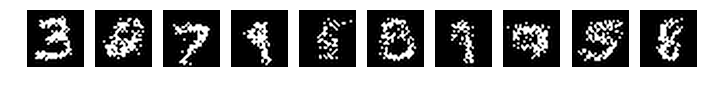

In [85]:
show_images(naive_model_d10_k10['model'].generate_samples(10))

### Визуализация латентного пространства

In [14]:
n = 15
digit_size = 28

from scipy.stats import norm
import numpy as np

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(model):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])

            x_decoded = model.generative_distr(Variable(torch.from_numpy(z_sample).float())).view(28, 28).data.numpy()
            digit = x_decoded
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')
    plt.show()

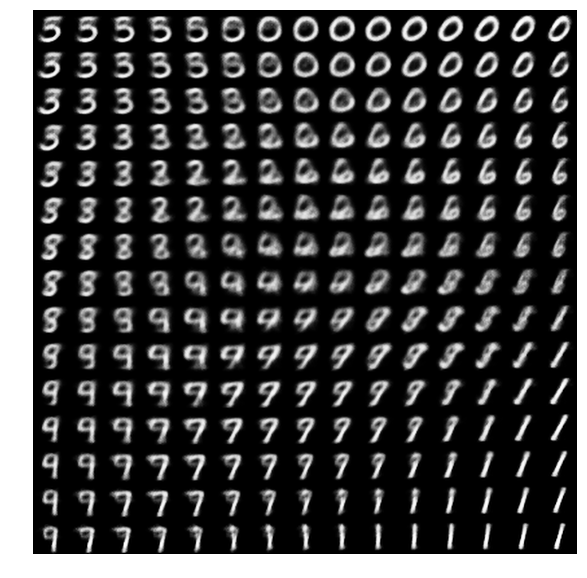

In [87]:
draw_manifold(naive_model_d2_k1['model'])

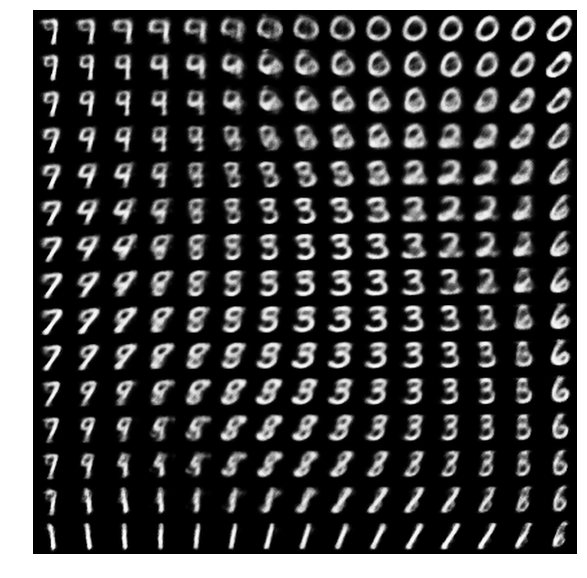

In [88]:
draw_manifold(naive_model_d2_k10['model'])

### Оценка правдоподобия тестовых данных в обученной модели методом Монте-Карло

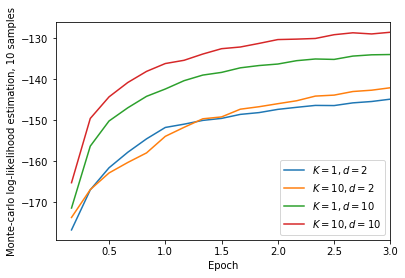

In [89]:
for label, model in [
    ('$K = 1, d = 2$', naive_model_d2_k1),
    ('$K = 10, d = 2$', naive_model_d2_k10),
    ('$K = 1, d = 10$', naive_model_d10_k1),
    ('$K = 10, d = 10$', naive_model_d10_k10)
]:
    data = [x['MC'] for x in model['test_results']]
    x_labels = (1 + np.arange(len(data))) / 6
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmax=x_labels[-1])
plt.ylabel('Monte-carlo log-likelihood estimation, 10 samples')
plt.legend()

Место для ваших выводов.

~

## Вариационный автокодировщик

Оптимизация, основанная на метде Монте-Карло, имеет недостатки. Какие?

Ваш ответ здесь:

~

Другой подход к максимизации правдоподобия - максимизация вариационной нижней оценки на логарифм правдоподобия:
$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x) = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x, z) q_\phi(z | x)}{q_\phi(z | x) p_\theta(z | x)} = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x, z)}{q_\phi(z | x)} + KL(q_\phi(z | x) || p_\theta(z | x))$$
$$\log p_\theta(x) \geqslant \mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x | z)p(z)}{q_\phi(z | x)} = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x | z) - KL(q_\phi(z | x) || p(z)) = L(x; \phi, \theta)
\to \max\limits_{\phi, \theta}$$

$q_\phi(z | x)$ называется предложным (proposal) или распознающим (recognition) распределением. Это гауссиана, чьи параметры задаются нейросетью с весами $\phi$:
$q_\phi(z | x) = \mathcal{N}(z | \mu_\phi(x), \sigma^2_\phi(x)I)$.
Обычно нейросеть моделирует не $\sigma_\phi(x)$, а $\log\sigma_\phi(x)$ или другую величину, более инвариантную к масштабу и определенную на всех вещественных числах так, чтобы $\sigma_\phi(x)$ было всегда положительным.

Зазор между вариационной нижней оценкой $L(x; \phi, \theta)$ на логарифм правдоподобия модели и самим логарифмом правдоподобия $\log p_\theta(x)$ - это KL-дивергенция между предолжным и апостериорным распределением на $z$: $KL(q_\phi(z | x) || p_\theta(z | x))$. Максимальное значение $L(x; \phi, \theta)$ при фиксированных параметрах модели $\theta$ достигается при $q_\phi(z | x) = p_\theta(z | x)$, но явное вычисление $p_\theta(z | x)$ требует слишком большого числа ресурсов, поэтому вместо этого вычисления вариационная нижняя оценка оптимизируется также по $\phi$. Чем ближе $q_\phi(z | x)$ к $p_\theta(z | x)$, тем точнее вариационная нижняя оценка.
Есть статьи, показывающие, что истинное апостериорное распределение $p_\theta(z | x)$ часто не может быть представлено одной гауссианой, поэтому зазор между нижней оценкой и логарифмом правдоподобия не достигает $0$. Тем не менее, этот зазор практически не влияет на процесс оптимизации модели и его результат по сравнению с другими факторами.

Первое слагаемое вариационной нижней оценки $\mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x | z)$ называется ошибкой восстановления (reconstruction loss).
Модель, соответствующая этой части - это автокодирощик с одним стохастическим слоем, пытающийся восстановить входной объект $x$.
Если распределение $q_\phi(z | x)$ - дельта-функция, то автокодировщик со стохастическим слоем превращается в обычный автокодировщик.
Поэтому $q_\phi(z | x)$ и $p_\theta(x | z)$ иногда называют энкодером и декодером соответственно.

Слагаемое $KL(q_\phi(z | x) || p(z))$ иногда называют регуляризатором.
Оно вынуждает $z \sim q_\phi(z | x)$ быть близким к $0$ и $q_\phi(z | x)$ быть близким к $p_\theta(z | x)$.
Иногда коэффициент при KL-дивергенции полагают не равным единице или даже используют другой регуляризатор.
Естественно, после этого обучение модели перестает соответствовать максимизации правдоподобия вышеописанной вероятностной модели данных.
Это существенно снижает интерпретируемость модели, устраняет её теоретические гарантии.
KL-дивергенция между двумя нормальными распределениями может быть вычислена аналитически.

Для максимизации $L(x; \phi, \theta)$ используется стохастический градиентный подъем.
Градиент ошибки восстановления по $\theta$ вычисляется с помощью метода обратного распространения ошибки.
$$\frac{\partial}{\partial \theta} L(x; \phi, \theta) = \mathbb{E}_{z \sim q_\phi(z | x)} \frac{\partial}{\partial \theta} \log p_\theta(x | z)$$

Градиент KL-дивергенции по $\phi$ может быть вычислен аналитически.
Для вычисления градиента по $\phi$ используется репараметризация (reparametrization trick):
$$\varepsilon \sim \mathcal{N}(\varepsilon | 0, I)$$
$$z = \mu + \sigma \varepsilon \Rightarrow z \sim \mathcal{N}(z | \mu, \sigma^2I)$$
$$\frac{\partial}{\partial \phi} L(x; \phi, \theta) = \mathbb{E}_{\varepsilon \sim \mathcal{N}(\varepsilon | 0, I)} \frac{\partial}{\partial \phi} \log p_\theta(x | \mu_\phi(x) + \sigma_\phi(x) \varepsilon) - \frac{\partial}{\partial \phi} KL(q_\phi(z | x) || p(z))$$

### Оценка логарифма правдоподобия: Importance Sampling (выборка по значимости)

Метод importance sampling оценки матожидания некоторой функции может быть использован для оценки правдоподобия модели. В качестве предложного распределения метода используется предложное распределение модели. Известно, что хороший выбор предложного распределения уменьшает дисперсию оценки. В случае вариационного автокодировщика оценки Монте-Карло, основанные на малом числе сэмплов, обычно занижены, поэтому imporatance sampling также позволяет получить более высокую и точную оценку правдоподобия с помощью меньшего числа сэмплов.

$$z_i \sim q_\phi(z | x), i = 1, \dots, K$$
$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} p_\theta(x | z) = \mathbb{E}_{z \sim q_\phi(z | x)} \frac{p_\theta(x | z) p(z)}{q_\phi(z | x)} \approx \frac{1}{K} \sum\limits_{i = 1}^K \frac{p_\theta(x | z_i) p(z_i)}{q_\phi(z_i | x)}$$

### Importance weighted autoencoders

Одно из обобщений вариационного автокодировщика. Показано, что такая нижняя оценка на логарифм правдоподобия имеет меньший зазор, чем оценка обычного вариационного автокодировщика, а при некоторых условиях стремится к настоящему логарифму правдоподобия при увеличении $K$. При $K = 1$ IWAE превращается в обычный вариационный автокодировщик.

$$z_i \sim q_\phi(z | x), i = 1, \dots, K$$
$$\log p_\theta(x) = \log \mathbb{E}_{z \sim p(z)} p_\theta(x | z) = 
\log \mathbb{E}_{z \sim q_\phi(z | x)} \frac{p_\theta(x | z)p(z)}{q_\phi(z | x)} = 
\log \mathbb{E}_{z_1, \dots, z_K \sim q_\phi(z | x)} \frac{1}{K}\sum\limits_{i=1}^{K}\frac{p_\theta(x | z_i)p(z_i)}{q_\phi(z_i | x)} \geqslant$$
$$\geqslant \mathbb{E}_{z_1, \dots, z_K \sim q_\phi(z | x)} \log \frac{1}{K}\sum\limits_{i=1}^{K}\frac{p_\theta(x | z_i)p(z_i)}{q_\phi(z_i | x)}
\approx
\log \frac{1}{K}\sum\limits_{i=1}^{K}\frac{p_\theta(x | z_i)p(z_i)}{q_\phi(z_i | x)} = L_k(x; \phi, \theta)$$

In [15]:
def kl(q_distr, p_distr):
    """
    Вычисляется KL-дивергенция KL(q || p) между n парами гауссиан.
    Вход: q_distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
    Первое - mu, второе - sigma.
    Вход: p_distr, tuple(Variable, Varable). Аналогично.
    Возвращаемое значение: Variable, вектор размерности n, каждое значение которого - 
    - KL-дивергенция между соответствующей парой распределений.
    """
    # ваш код здесь
    nu_1, sigma_1 = q_distr
    nu_2, sigma_2 = p_distr
    
    one_half = Variable(torch.FloatTensor([0.5]))
#     print('sigma1log', sigma_1.log().mean())
#     print('sigma2log', sigma_2.log().mean())
#     print('nu2', nu_2.mean())
#     print('nu1', nu_1.mean())
#     print('sigma1', sigma_1.mean())
#     print('1/sigma2', 1/sigma_2.mean())
#     print('AAAAAAHCK KL',(-sigma_1.log()).mean(), sigma_2.log().mean(), (sigma_1 ** 2).sum(),\
#           ((nu_2 - nu_1) ** 2).mean(), (one_half / (sigma_2 ** 2)).mean())
    kl_div = -sigma_1.log() + sigma_2.log() - one_half +\
        (sigma_1 ** 2 + (nu_2 - nu_1) ** 2) * one_half / (sigma_2 ** 2)
    kl_div = kl_div.sum(dim=1)
    return kl_div

In [16]:
class VAE(nn.Module):
    def __init__(self, d, D):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D = D
        self.proposal_network = nn.Sequential(
            nn.Linear(self.D, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
        )
        self.proposal_mu_head = nn.Linear(200, self.d)
        self.proposal_sigma_head = nn.Linear(200, self.d)
        self.generative_network = nn.Sequential(
            nn.Linear(self.d, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.D),
            nn.Sigmoid()
        )

    def proposal_distr(self, x):
        """
        Генерирует предложное распределение на z.
        Вход: x, Variable - матрица размера n x D.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        # ваш код здесь
        proposal = self.proposal_network(x)
        mu, sigma = self.proposal_mu_head(proposal), self.proposal_sigma_head(proposal).exp()
        return mu, sigma

    def prior_distr(self, n):
        """
        Генерирует априорное распределение на z.
        Вход: n, int - число распределений.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        
        mu = Variable(torch.FloatTensor([0] * n * self.d)).view(n, self.d)
        sigma = Variable(torch.FloatTensor([1] * n * self.d)).view(n, self.d)
        return mu, sigma

    def sample_latent(self, distr, K=1):
        """
        Генерирует сэмплы из гауссовского распределения на z.
        Сэмплы должны быть дифференцируемы по параметрам распределения!
        Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, матрица размера n x d.
        """
        # ваш код здесь
        nu, sigma = distr
        n, d = nu.shape
        prior = self.sample_prior(K * n).view(K, n, d)
        latent = nu.view(1, n, d) + sigma.view(1, n, d) * prior
        return latent.view(n * K, d)

    def sample_prior(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        # ваш код здесь
        return Variable(torch.randn(num_samples, self.d))

    def generative_distr(self, z):
        """
        По матрице латентных представлений z возвращает матрицу параметров
        распределения Бернулли для сэмплирования объектов x.
        Вход: z, Variable - матрица n x d латентных представлений.
        Возвращаемое значение: Variable, матрица параметров распределения
        Бернулли размера n x D.
        """
        # ваш код здесь
        distr = self.generative_network(z).clamp(1e-10, 1-1e-10)
#         print('DEBUG', distr.min(), distr.max())
        return distr

    def batch_loss(self, batch, K):
        """
        Вычисляет вариационную нижнюю оценку логарифма правдоподобия по батчу
        используя K сэмплов для каждого объекта.
        Вариационная нижняя оценка должна быть дифференцируема по параметрам модели (!),
        т. е. надо использовать репараметризацию.
        Вход: batch, Variable - матрица объектоа размера n x D.
        Вход: K, int - число сэмплов для каждого объекта, не используется.
        Возвращаемое значение: Variable, скаляр - вариационная нижняя оценка
        правдоподобия по батчу.
        """
        # ваш код здесь
        n, D = batch.shape
        prior = self.prior_distr(n)
        proposal = self.proposal_distr(batch)
        latent = self.sample_latent(proposal, K)
        generative = self.generative_distr(latent)
        kl_div = kl(proposal, prior)
        log_p = log_mean_exp(binary_crossentropy_loss(batch, generative))
#         print(kl_div.mean(dim=0)) # log_p.mean(), generative.mean(), proposal[0].abs().max(), proposal[1].abs().max())
        return (log_p - kl_div).mean(dim=0)
#         return -log_p.mean(dim=0)
#         return -kl_div.mean(dim=0)
    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        # ваш код здесь
        mu, sigma = self.prior_distr(num_samples)
        latent = self.sample_latent((mu, sigma), 1)
        generative = self.generative_distr(latent)
        return torch.bernoulli(generative)

In [17]:
def gaussian_log_pdf(distr, samples):
    """
    Функция вычисляет логарифм плотности вероятности в точке относительно соответствующего
    нормального распределения, заданного покомпонентно своими средним и среднеквадратичным отклонением.
    Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
    Первое - mu, второе - sigma.
    Вход: samples, Variable - матрица размера (n * K) x d сэмплов в скрытом пространстве.
    Возвращаемое значение: Variable, вектор длины n * K, каждый элемент которого - логарифм
    плотности вероятности точки относительно соответствующего распределения. Точке с номером i
    соответствует распределение с номером i // K.
    """
    mu, sigma = distr
    K = samples.shape[0] // mu.shape[0]
    n, d = mu.shape
    # ваш код здесь
    samples = samples.view(K, n, d)
    mu, sigma = mu.view(1, n, d), sigma.view(1, n, d)
    two = Variable(torch.FloatTensor([2]))
    log_pdf = ((-two.log() / two - sigma.log()) + (samples - mu) ** 2 / two / sigma ** 2).sum(dim=2)
    return log_pdf.view(n * K)

In [18]:
def compute_log_likelihood_importance_sampling(batch, model, K):
    """
    Функция, оценку логарифма правдоподобия вероятностной модели по батчу методом Importance Sampling.
    Вход: batch, FloatTensor - матрица размера n x D
    Вход: model, Module - объект, имеющий методы prior_distr, proposal_distr, sample_latent и generative_distr,
    описанные в VAE.
    Вход: K, int - количество сэмплов.
    Возвращаемое значение: float - оценка логарифма правдоподобия.
    """
    # ваш код здесь
    n, D = batch.shape
    proposal_distr = model.proposal_distr(batch)
    latent = model.sample_latent(proposal_distr, K)
    generated_distr = model.generative_distr(latent)
    prior_distr = model.prior_distr(K * n).view(n, K, model.d)
    p_x_z_log = binary_crossentropy_loss(batch, generated_distr).view(K, n)
    q_z_x_log = gaussian_log_pdf(proposal_distr, latent).view(K, n)
    p_z_log = gaussian_log_pdf(prior_distr, latent).view(K, 1)
    log_likelihood = p_x_z_log + p_z_log - q_z_x_log
    return log_mean_exp(log_likelihood).mean(dim=0).data.numpy()

def model_test_log_likelihood_importance_sampling(model, K=10, batch_size=100, max_batches=None, verbose=False):
    """
    Функция, вовращает оценку логарифма правдоподобия данной модели по тестовым данным.
    Вход: model, Module - объект, имеющий методы prior_distr, proposal_distr, sample_latent и generative_distr,
    описанные в VAE.
    Вход: K, int - количество сэмплов.
    Остальные входы описаны в функции model_test_loss.
    Возвращаемое значение: float - оценка логарифма правдоподобия.    
    """
    return model_test_loss(lambda batch: compute_log_likelihood_importance_sampling(batch, model, K),
                           batch_size=batch_size,
                           max_batches=max_batches,
                           verbose=verbose)


In [19]:
vae_tests = [
    {
        'name': 'MC',
        'func': lambda model: model_test_log_likelihood_monte_carlo(model, max_batches=20)
    },
    {
        'name': 'IS',
        'func': lambda model: model_test_log_likelihood_importance_sampling(model, max_batches=20)
    }
]

In [33]:
vae_model_d2_k1 = train_model(VAE(2, 784), tests=vae_tests)

Train loss: -191.12 Batch 100 of 600           
Train loss: -168.832 Batch 200 of 600           
Train loss: -160.623 Batch 300 of 600           
Train loss: -157.593 Batch 400 of 600           
Train loss: -164.949 Batch 500 of 600           
Train loss: -165.769 Batch 600 of 600           
Train loss: -160.501 Batch 100 of 600           
Train loss: -146.998 Batch 200 of 600           
Train loss: -152.684 Batch 300 of 600           
Train loss: -141.275 Batch 400 of 600           
Train loss: -147.042 Batch 500 of 600           
Train loss: -153.393 Batch 600 of 600           
Train loss: -152.081 Batch 100 of 600           
Train loss: -153.214 Batch 200 of 600           
Train loss: -145.188 Batch 300 of 600           
Train loss: -153.148 Batch 400 of 600           
Train loss: -148.975 Batch 500 of 600           
Train loss: -152.6 Batch 600 of 600             


In [37]:
vae_model_d10_k1 = train_model(VAE(10, 784), tests=vae_tests)

Train loss: -170.984 Batch 100 of 600           
Train loss: -168.538 Batch 200 of 600           
Train loss: -161.196 Batch 300 of 600           
Train loss: -165.052 Batch 400 of 600           
Train loss: -152.759 Batch 500 of 600           
Train loss: -151.668 Batch 600 of 600           
Train loss: -149.359 Batch 100 of 600           
Train loss: -145.537 Batch 200 of 600           
Train loss: -149.386 Batch 300 of 600           
Train loss: -150.823 Batch 400 of 600           
Train loss: -153.28 Batch 500 of 600            
Train loss: -158.816 Batch 600 of 600           
Train loss: -145.466 Batch 100 of 600           
Train loss: -152.076 Batch 200 of 600           
Train loss: -147.61 Batch 300 of 600            
Train loss: -149.044 Batch 400 of 600           
Train loss: -144.546 Batch 500 of 600           
Train loss: -155.569 Batch 600 of 600           


## Оценка качества модели

### Визуальная оценка генерируемых объектов

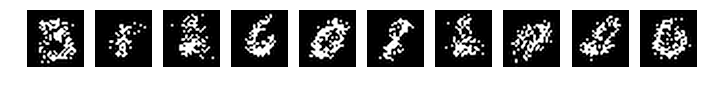

In [34]:
show_images(vae_model_d2_k1['model'].generate_samples(10))

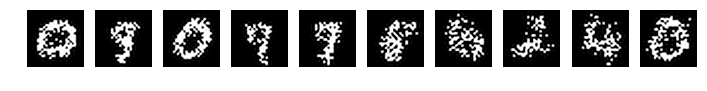

In [38]:
show_images(vae_model_d10_k1['model'].generate_samples(10))

### Визуализация латентного пространства (с точки зрения декодера)

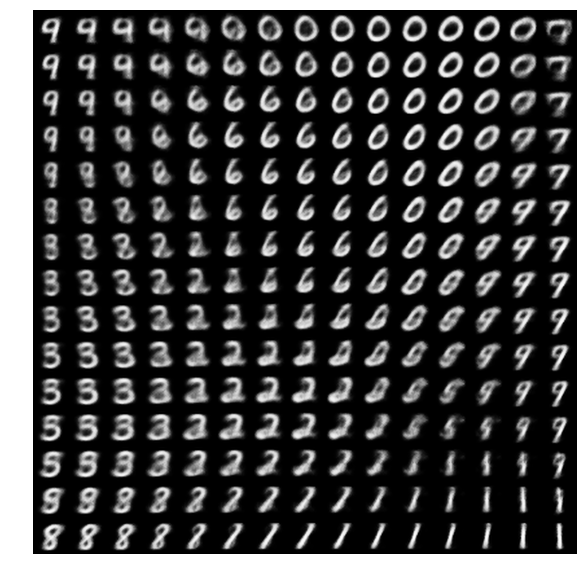

In [35]:
draw_manifold(vae_model_d2_k1['model'])

### Визуализация латетного пространства (с точки зрения энкодера)

In [20]:
def draw_latent_space(data, target, encoder):
    z_test = encoder(data)
    plt.figure(figsize=(7, 6))
    plt.scatter(z_test[:, 0], z_test[:, 1], c=target, cmap='gist_rainbow', alpha=0.75)
    plt.colorbar()
    plt.show()

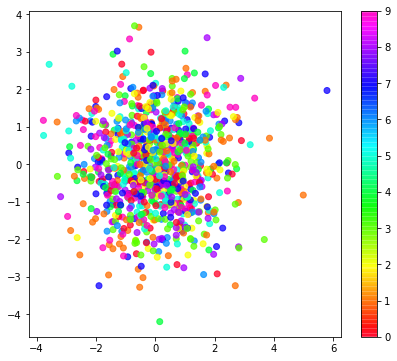

In [40]:
model_encoder = lambda data, model: model.sample_latent(model.proposal_distr(Variable(data)))
draw_latent_space(test_data.data_tensor[::10], test_data.target_tensor[::10],
                  lambda data: model_encoder(data, vae_model_d2_k1['model']))

In [41]:
from sklearn.manifold import TSNE

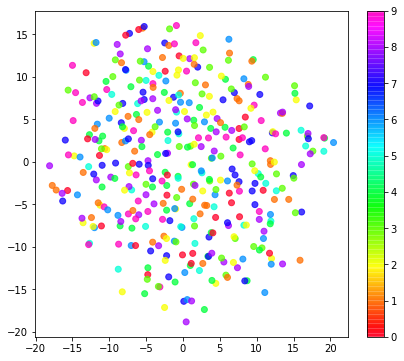

In [42]:
encoder_d10 = lambda data: TSNE().fit_transform(model_encoder(data, vae_model_d10_k1['model']).data.numpy())
draw_latent_space(test_data.data_tensor[::25], test_data.target_tensor[::25], encoder_d10)

### Оценки логарифма правдоподобия на тестовых данных

ValueError: x and y can be no greater than 2-D, but have shapes (18,) and (18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

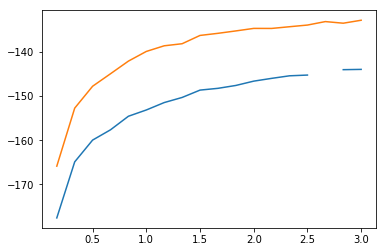

In [100]:
for label, name, model in [
#     ('Naive, Monte-Carlo, $K = 10, d = 2$', 'MC', naive_model_d2_k10),
#     ('Naive, Monte-Carlo, $K = 10, d = 10$', 'MC', naive_model_d10_k10),
    ('VAE, Monte-Carlo, $K = 1, d = 2$', 'MC', vae_model_d2_k1),
    ('VAE, Monte-Carlo, $K = 1, d = 10$', 'MC', vae_model_d10_k1),
    ('VAE, Importance Sampling, $K = 1, d = 2$', 'IS', vae_model_d2_k1),
    ('VAE, Importance Sampling, $K = 1, d = 10$', 'IS', vae_model_d10_k1),
]:
    data = [x[name] for x in model['test_results']]
    x_labels = (1 + np.arange(len(data))) / 6
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmax=x_labels[-1])
plt.ylabel('Log-likelihood estimation, 10 samples')
plt.legend()

In [99]:
test_results = []
for K in [1, 5, 10, 50, 100, 500, 1000, 5000]:
    print(K, flush=True)
    vae_tests_sampling = [
        {
            'name': 'D10MC',
            'func': lambda: model_test_log_likelihood_monte_carlo(vae_model_d10_k1['model'],
                                                                        batch_size=10, K=K, max_batches=50)
        },
        {
            'name': 'D10IS',
            'func': lambda: model_test_log_likelihood_importance_sampling(vae_model_d10_k1['model'],
                                                                                batch_size=10, K=K, max_batches=50)
        },
        {
            'name': 'D2MC',
            'func': lambda: model_test_log_likelihood_monte_carlo(vae_model_d2_k1['model'],
                                                                        batch_size=10, K=K, max_batches=50)
        },
        {
            'name': 'D2IS',
            'func': lambda: model_test_log_likelihood_importance_sampling(vae_model_d2_k1['model'],
                                                                                batch_size=10, K=K, max_batches=50)
        }
    ]
    cur_test_results = {'K': K}
    for test in vae_tests_sampling:
        cur_test_results[test['name']] = test['func']()
    test_results.append(cur_test_results)

1
5
10
50
100
500
1000
5000


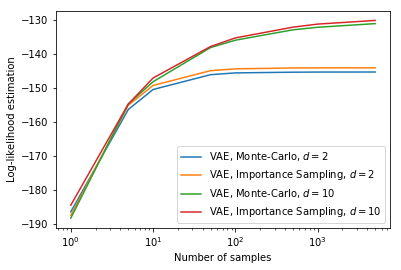

In [101]:
for label, name in [
    ('VAE, Monte-Carlo, $d = 2$', 'D2MC'),
    ('VAE, Importance Sampling, $d = 2$', 'D2IS'),
    ('VAE, Monte-Carlo, $d = 10$', 'D10MC'),
    ('VAE, Importance Sampling, $d = 10$', 'D10IS'),
]:
    data = [x[name] for x in test_results]
    x_labels = [x['K'] for x in test_results]
    plt.plot(x_labels, data, label=label)
plt.xlabel('Number of samples')
plt.xscale('log')
plt.ylabel('Log-likelihood estimation')
plt.legend()

Место для ваших выводов.

~

# Обусловленные вариационные автокодировщики

## Постановка задачи
Дан датасет $(x_i, y_i)$ for $i = 1, \dots, N$, в котором $y_i \sim p_d(y | x_i)$ для каждого $i$ и $p_d$ --- истинное распределение данных.

Требуется построить вероятностную модель $p_{\psi, \theta}(y | x)$ истинного распределения $p_d(y | x)$.

Модель $p_{\psi, \theta}(y | x)$ должна позволять вычислять плотность вероятности для данных $y$ и $x$, а также сэмплировать $y \sim p_{\psi, \theta}(y | x)$.

При этом пространства значений $x$ и $y$ обычно имеют сложную структуру (например, изображения), а истинное условное распределение $p_d(y | x)$ может иметь много мод (локальных максимумов).

## Вероятностная модель
$z \in \mathbb{R}^d$ - пространство локальных латентных переменных.

Генеративная процесс обусловленного вариационного автокодировщика:
1. Сэмплируем $z \sim p_\psi(z| x)$.
2. Сэмплируем $y \sim p_\theta(y | z, x)$.

Параметры распределений $p_\psi(z | x)$, $p_\theta(y | z, x)$ задаются нейросетями с весами $\psi$ и $\theta$.

Плотность вероятности индуцируемого моделью распределения:

$$p_{\psi, \theta}(y | x) = \mathbb{E}_{z \sim p_\psi(z | x)} p_\theta(y | z, x)$$

Можно заметить, что если в вариаицонном автокодировщике переименовать $x$ в $y$ и обусловить все распределения на новую переменную $x$, получится обусловленный вариационный автокодировщик.

Таким же методом можно вывести вариационную нижнюю оценку для обусловленного вариационного автокодировщика:

$$\log p_{\psi, \theta}(y | x) = \mathbb{E}_{z \sim q_\phi(z | x, y)} \log p_\theta(y | x) = 
\mathbb{E}_{z \sim q_\phi(z | x, y)} \log \frac{p_{\psi, \theta}(y, z | x) q_\phi(z | x, y)}{q_\phi(z | x, y) p_{\psi, \theta}(z | x, y)} = 
\mathbb{E}_{z \sim q_\phi(z | x, y)} \log \frac{p_{\psi, \theta}(y, z | x)}{q_\phi(z | x, y)} + KL(q_\phi(z | x, y) || p_{\psi, \theta}(z | x, y))$$
$$\log p_{\psi, \theta}(y | x) \geqslant \mathbb{E}_{z \sim q_\phi(z | x, y)} \log \frac{p_\theta(y | z, x)p_\psi(z | x)}{q_\phi(z | x, y)} = 
\mathbb{E}_{z \sim q_\phi(z | x, y)} \log p_\theta(y | z, x) - KL(q_\phi(z | x, y) || p_\psi(z | x)) = L(x, y; \phi, \psi, \theta)
\to \max\limits_{\phi, \psi, \theta}$$

В этой модели используется репараметризация для вычисления градиента по $\phi$, как и в обычном вариационном автокодировщике.
Обратите внимание, что в этой модели обучаются уже три нейросети, а не две, как было в автокодировщике.
Третья нейросеть параметризует распределение $p_\psi(z | x)$, полученное после обуславливания на $x$ апроирного распределения на $z$.
Skip connections и другие виды разделения весов между априорной и генеративной нейросетями допустимы.

Оценки логарифма правдоподобия Monte-Carlo и Importance Sampling, Importance Weighted версия модели и всё остальное получаются аналогично.

Monte-Carlo:
$$z_i \sim p_\psi(z | x), i = 1, \dots, K$$
$$p_{\psi, \theta}(y | x) \approx \frac{1}{K} \sum\limits_{i = 1}^K p_\theta(y | z_i, x)$$

Importance Sampling:
$$z_i \sim q_\phi(z | x, y), i = 1, \dots, K$$
$$p_{\psi, \theta}(y | x) = \mathbb{E}_{z \sim p_\psi(z | x)} p_\theta(y | z, x) = \mathbb{E}_{z \sim q_\phi(z | x, y)} \frac{p_\theta(y | z, x) p_\psi(z | x)}{q_\phi(z | x, y)} \approx \frac{1}{K} \sum\limits_{i = 1}^K \frac{p_\theta(y | z_i, x) p_\psi(z_i | x)}{q_\phi(z_i | x, y)}$$

Importance Weighted Conditional Autoencoder:
$$z_i \sim q_\phi(z | x, y), i = 1, \dots, K$$
$$\log p_{\psi, \theta}(y | x) = \log \mathbb{E}_{z \sim p_\psi(z | x)} p_\theta(y | z, x) = 
\log \mathbb{E}_{z \sim q_\phi(z | x, y)} \frac{p_\theta(y | z, x) p_\psi(z | x)}{q_\phi(z | x, y)} = 
\log \mathbb{E}_{z_1, \dots, z_K \sim q_\phi(z | x, y)} \frac{1}{K}\sum\limits_{i=1}^{K}\frac{p_\theta(y | z_i, x) p_\psi(z_i | x)}{q_\phi(z_i | x, y)} \geqslant$$
$$\geqslant \mathbb{E}_{z_1, \dots, z_K \sim q_\phi(z | x, y)} \log \frac{1}{K}\sum\limits_{i=1}^{K}\frac{p_\theta(y | z_i, x) p_\psi(z_i | x)}{q_\phi(z_i | x, y)}
\approx
\log \frac{1}{K}\sum\limits_{i=1}^{K}\frac{p_\theta(y | z_i, x) p_\psi(z_i | x)}{q_\phi(z_i | x, y)} = L_k(x, y; \phi, \psi, \theta)$$

## Гибридная модель

Как мы видели в прошлой секции, модель на основе вариационной нижней оценки имеет лучшее правдоподобие, но требуется слишком много сэмплов $z$ чтобы оценка методом Монте-Карло достигла этого значения.
Другая причина предложения гибридной модели - то, что некоторые области высокой вероятности $p_\psi(z | x_i)$ могут иметь малую вероятность $q_\theta(z | x, y)$ для всех $(x_i, y_i)$ из датасета, и $z$ из таких областей не участвуют в оптимизации на стадии обучения, поэтому генератор может выдать абсолютно неправдоподобный результат, увидев такую точку впервые на стадии тестирования.

Гибридная модель - это взвешенная смесь гауссовской стохастической нейросети (Gaussian Stochastic Neural Network) и обусловленного вариационного автокодировщика.

Гауссовская стохастическая нейросеть - это обусловленный вариационный автокодировщик, в котором предложное распределение не зависит от $y$ и соделируется той же нейросетью, что и априорное: $q_\phi(z | x, y) = p_\psi(z | x)$.
Эта модель называется гауссовской стохастической нейросетью, потому что она модет быть реализована одной нейросетью, в которой один из слоев - стохастический гауссовский. Гауссовская стохастическая нейросеть - это аналог обучения вероятностной модели вариационного автокодировщика с помощью метода Монте-Карло, рассматривавшийся в начале этого задания, поскольку в обоих случаях не используется предложное распределение.

$$L_{GSNN}(x, y; \psi, \theta) = \mathbb{E}_{z \sim p_\psi(z | x)} \log p_\theta(y | z, x)$$
$$L_{hybrid}(x, y; \phi, \psi, \theta) = \alpha L(x, y; \phi, \psi, \theta) + (1 - \alpha) L_{GSNN}(x, y; \psi, \theta) $$

В этой части задания будем предсказывать нижнюю половину картинки по верхней.

В качестве функции правдоподобия используем следующую функцию распределения над бесконечным дискретным носителем, содержащим точки вида $\frac{n}{256}$, $n \in \mathbb{Z}$.
$$p(x | \mu, s) = CDF(x + \frac{1}{256} | \mu, s) - CDF(x | \mu, s)$$
$$CDF(x | \mu, s) = \frac{1}{1 + e^{-\frac{x - \mu}{s}}}$$
Эта функция называется дискретной логистической функцией потерь. Параметры $\mu$ моделирутся нейросетью для каждого пикселя, а настраиваемый параметр $\log s$ общий для всей модели и всех изображений.

In [21]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 256, data.train_labels)
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 256, data.test_labels)

In [22]:
def discretized_logistic_loss(x_true, x_distr, log_s):
    """
    Вычисляет дискретную логистическую плотность объектов x_true.
    Каждому объекту из x_true соответствуют K сэмплированных распределений
    на x из x_distr.
    i-му объекту соответствуют распределения с номерами i * K, ..., (i + 1) * K - 1.
    Требуется вычислить оценку логарифма правдоподобия для каждого объекта.
    Подсказка: не забывайте про вычислительную стабильность!

    Вход: x_true, Variable - матрица объектов размера n x D.
    Вход: x_distr, Variable - матрица параметров распределений Бернулли
    размера (n * K) x D.
    Выход: Variable, матрица размера n x K - оценки логарифма правдоподобия
    каждого сэмпла.
    """
    K = x_distr.shape[0] // x_true.shape[0]
    n, D = x_true.shape
    cdfi = lambda x: 1 / (1+(-(x.view(n, D, 1) - x_distr.view(K, n, D).permute(1,2,0)) / log_s.exp()).exp())
    p = (cdfi(x_true + Variable(torch.FloatTensor([1 / 256]))) - cdfi(x_true)).log()
#     print()
    return p.sum(dim=1)

In [118]:
class CVAE(nn.Module):
    def __init__(self, d, D_x, D_y, alpha):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D_x, int - размерность пространства x.
        Вход: D_y, int - размерность пространства y.
        Вход: alpha, float - число от 0 до 1, коэффициент смеси моделей СVAE и GSNN.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D_x = D_x
        self.D_y = D_y
        self.alpha = alpha
        self.log_s = nn.Parameter(torch.zeros(1))
        self.i = 0
        self.proposal_network = nn.Sequential(*[
            nn.Linear(self.D_x + self.D_y, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
        ])
        self.proposal_mu_head = nn.Linear(200, self.d)
        self.proposal_sigma_head = nn.Linear(200, self.d)
        self.prior_network = nn.Sequential(*[
            nn.Linear(self.D_x, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
        ])
        self.prior_mu_head = nn.Linear(200, self.d)
        self.prior_sigma_head = nn.Linear(200, self.d)
        self.generative_network = nn.Sequential(*[
            nn.Linear(self.d, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.D_y),
            nn.Sigmoid()
        ])

    def proposal_distr(self, x, y):
        """
        Генерирует предложное распределение на z.
        Вход: x, Variable - матрица размера n x D_x.
        Вход: y, Variable - матрица размера n x D_y.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        # ваш код здесь
        proposal = self.proposal_network(torch.cat([x, y], dim=1))
        mu, sigma = self.proposal_mu_head(proposal), self.proposal_sigma_head(proposal).exp()
        return mu, sigma

    def prior_distr(self, x):
        """
        Генерирует априорное распределение на z.
        Вход: x, Variable - матрица размера n x D_x.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        # ваш код здесь
        prior = self.prior_network(x)
        mu = self.prior_mu_head(prior)
        sigma = self.prior_sigma_head(prior).exp()
        return mu, sigma

    def sample_latent(self, distr, K=1):
        """
        Генерирует сэмплы из гауссовского распределения на z.
        Сэмплы должны быть дифференцируемы по параметрам распределения!
        Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, матрица размера n x d.
        """
        # ваш код здесь
        mu, sigma = distr
        n, d = mu.shape
        eps = Variable(torch.randn(n * K * d)).view(n, K, d)
        z = mu.view(n, 1, d) + eps * sigma.view(n, 1, d)
        return z.view(n * K, d)

    def generative_distr(self, z):
        """
        По матрице латентных представлений z возвращает матрицу параметров
        распределения Бернулли для сэмплирования объектов y.
        Вход: z, Variable - матрица n x d латентных представлений.
        Возвращаемое значение: Variable, матрица параметров распределения
        Бернулли размера n x D.
        """
        # ваш код здесь
        return self.generative_network(z)

    def batch_loss(self, batch, K, alpha=None):
        """
        Вычисляет вариационную нижнюю оценку логарифма правдоподобия по батчу
        используя K сэмплов для каждого объекта.
        Вариационная нижняя оценка должна быть дифференцируема по параметрам модели (!),
        т. е. надо использовать репараметризацию.
        Вход: batch, Variable - матрица объектов размера n x (D_x + D_y).
        Первые D_x столбцов - x, остальные столбцы соответствуют y.
        Вход: K, int - число сэмплов для каждого объекта, не используется.
        Вход: alpha, float - коэффициент смеси моделей можно задавать для каждого батча,
        но если он не задан, то используется значение, указанное при создании объекта класса.
        Возвращаемое значение: Variable, скаляр - вариационная нижняя оценка
        правдоподобия по батчу.
        """
        if alpha is None:
            alpha = self.alpha
        x = batch[:, :self.D_x].contiguous()
        y = batch[:, self.D_x: self.D_x + self.D_y].contiguous()
        proposal_distr = self.proposal_distr(x, y)
        prior_distr = self.prior_distr(x)
        proposal_z = self.sample_latent(proposal_distr)
        prior_z = self.sample_latent(prior_distr)
        proposal_generated = self.generative_distr(proposal_z)
        prior_generated = self.generative_distr(prior_z)
#         logp_y_proposal = log_mean_exp(discretized_logistic_loss(y, proposal_generated, self.log_s)).mean(dim=0)
#         logp_y_prior = log_mean_exp(discretized_logistic_loss(y, prior_generated, self.log_s)).mean(dim=0)
        print(y.min().data.numpy(), y.max().data.numpy(),
              proposal_generated.min().data.numpy(),
              proposal_generated.max().data.numpy(),
              binary_crossentropy_loss((y).round(), proposal_generated).min().data.numpy(),
              binary_crossentropy_loss((y).round(), proposal_generated).max().data.numpy()
             )
        logp_y_proposal = log_mean_exp(binary_crossentropy_loss((y).round(), proposal_generated)).mean(dim=0)
        logp_y_prior = log_mean_exp(binary_crossentropy_loss((y).round(), prior_generated)).mean(dim=0)

        kl_div = kl(proposal_distr, prior_distr).mean(dim=0)
        loss = logp_y_proposal - kl_div
        loss_gsnn = logp_y_prior
        print(kl_div.data.numpy(), logp_y_proposal.data.numpy(), logp_y_prior.data.numpy())
#         print(logp_y_proposal.data.numpy(), kl_div.data.numpy(), loss_gsnn.data.numpy())
        return loss * alpha + loss_gsnn * (1 - alpha)
        
        

    def generate_samples(self, x, K):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        # ваш код здесь
        mu, sigma = self.prior_distr(x)
        z = self.sample_latent((mu, sigma), K)
        generative = self.generative_distr(z)
        return generative

In [119]:
def cvae_compute_log_likelihood_monte_carlo(batch, model, K):
    """
    Функция, оценку логарифма правдоподобия вероятностной модели по батчу методом Монте-Карло.
    Вход: batch, FloatTensor - матрица размера n x D
    Вход: model, Module - объект, имеющий методы sample_prior и generative_distr, описанные в NaiveModel.
    Вход: K, int - количество сэмплов.
    Возвращаемое значение: float - оценка логарифма правдоподобия.
    """
    # ваш код здесь
    
    x = batch[:, :model.D_x].contiguous()
    y = batch[:, model.D_x: model.D_x + model.D_y].contiguous()
    prior_distr = model.prior_distr(x)
    prior_z = model.sample_latent(prior_distr, K=K)
    prior_generated = model.generative_distr(prior_z)
    return log_mean_exp(discretized_logistic_loss(y, prior_generated, model.log_s)).mean().data.numpy()


def cvae_test_log_likelihood_monte_carlo(model, K=10, batch_size=100, max_batches=None, verbose=False):
    """
    Функция, вовращает оценку логарифма правдоподобия данной модели по тестовым данным.
    Вход: model, Module - объект, имеющий методы sample_prior и generative_distr, описанные в NaiveModel.
    Вход: K, int - количество сэмплов.
    Остальные входы описаны в функции model_test_loss.
    Возвращаемое значение: float - оценка логарифма правдоподобия.    
    """
    return model_test_loss(lambda batch: cvae_compute_log_likelihood_monte_carlo(batch, model, K),
                           batch_size=batch_size,
                           max_batches=max_batches,
                           verbose=verbose)

In [120]:
def cvae_compute_log_likelihood_importance_sampling(batch, model, K):
    """
    Функция, оценку логарифма правдоподобия вероятностной модели по батчу методом Importance Sampling.
    Вход: batch, FloatTensor - матрица размера n x D
    Вход: model, Module - объект, имеющий методы prior_distr, proposal_distr, sample_latent и generative_distr,
    описанные в CVAE.
    Вход: K, int - количество сэмплов.
    Возвращаемое значение: float - оценка логарифма правдоподобия.
    """
    # ваш код здесь
    x = batch[:, :model.D_x].contiguous()
    y = batch[:, model.D_x: model.D_x + model.D_y].contiguous()
    n, d = y.shape
    prior_distr = model.prior_distr(x)
    proposal_distr = model.proposal_distr(x, y)
    proposal_z = model.sample_latent(proposal_distr, K)
    proposal_generated = model.generative_distr(proposal_z)
    p_y = discretized_logistic_loss(y, proposal_generated, model.log_s)
    p_proposal_z = gaussian_log_pdf(proposal_distr, proposal_z).view(n, K)
    p_prior_z = gaussian_log_pdf(prior_distr, proposal_z).view(n,K)
#     print(discretized_logistic_loss(y, proposal_generated, model.log_s).shape)
#     print(y.shape, proposal_generated.shape, p_y.shape, p_proposal_z.shape, p_prior_z.shape)
    p = p_y + p_prior_z - p_proposal_z
    return log_mean_exp(p).mean(dim=0)

def cvae_test_log_likelihood_importance_sampling(model, K=10, batch_size=100, max_batches=None, verbose=False):
    """
    Функция, вовращает оценку логарифма правдоподобия данной модели по тестовым данным.
    Вход: model, Module - объект, имеющий методы prior_distr, proposal_distr, sample_latent и generative_distr,
    описанные в CVAE.
    Вход: K, int - количество сэмплов.
    Остальные входы описаны в функции model_test_loss.
    Возвращаемое значение: float - оценка логарифма правдоподобия.    
    """
    return model_test_loss(lambda batch: cvae_compute_log_likelihood_importance_sampling(batch, model, K),
                           batch_size=batch_size,
                           max_batches=max_batches,
                           verbose=verbose)

In [121]:
cvae_tests = [
    {
        'name': 'MC',
        'func': lambda model: cvae_test_log_likelihood_monte_carlo(model, max_batches=20)
    },
    {
        'name': 'IS',
        'func': lambda model: cvae_test_log_likelihood_importance_sampling(model, max_batches=20)
    }
]

In [ ]:
cvae_model_d10_a1 = train_model(CVAE(10, 392, 392, 1), tests=cvae_tests, learning_rate=5e-3)

[ 0.] [ 0.99609375] [ 0.38952139] [ 0.61957556] [-276.89920044] [-269.12002563]
[ 0.12116493] [-272.03939819] [-272.02893066]
[ 0.] [ 0.99609375] [ 0.27659851] [ 0.60409534] [-265.37506104] [-228.82012939]
[ 1.93256211] [-241.8891449] [-245.4138031]
[ 0.] [ 0.99609375] [ 0.05220999] [ 0.85137635] [-249.32566833] [-124.97861481]
[ 1.34426606] [-173.18577576] [-199.1967926]
[ 0.] [ 0.99609375] [ 0.0003287] [ 0.95465857] [-344.22369385] [-58.20219421]
[ 6.24765301] [-129.26296997] [-159.3321228]
[ 0.] [ 0.99609375] [ 0.00047991] [ 0.9003166] [-315.97906494] [-51.15110779]
[ 2.61724997] [-120.92900085] [-125.42215729]
[ 0.] [ 0.99609375] [  5.74293117e-05] [ 0.81162292] [-283.5118103] [-54.95102692]
[ 1.15096807] [-110.38796997] [-111.14402008]
[ 0.] [ 0.99609375] [  1.61664263e-06] [ 0.89732337] [-387.597229] [-55.68579102]
[ 1.51666355] [-112.04705048] [-111.88427734]
[ 0.] [ 0.99609375] [  9.07925679e-10] [ 0.91297096] [-744.91876221] [-54.31248474]
[ 1.798841] [-112.09070587] [-112.449

[ 0.] [ 0.99609375] [  1.23010499e-12] [ 0.99914026] [-1282.16308594] [-25.98660851]
[ 0.13424933] [-81.0029068] [-80.16352844]
[ 0.] [ 0.99609375] [  8.62424711e-18] [ 0.99970394] [-1515.88098145] [-16.49281502]
[ 0.08235526] [-79.70986176] [-80.18653107]
[ 0.] [ 0.99609375] [  5.46849831e-17] [ 0.99955827] [-1395.79418945] [-22.36213875]
[ 0.0696597] [-79.81348419] [-79.07068634]
[ 0.] [ 0.99609375] [  5.76723651e-12] [ 0.99908388] [-837.49737549] [-26.04318237]
[ 0.0832852] [-81.47097015] [-80.1565094]
[ 0.] [ 0.99609375] [  2.41517362e-11] [ 0.99972528] [-955.29901123] [-25.4955864]
[ 0.07398956] [-82.12973785] [-82.41661072]
[ 0.] [ 0.99609375] [  7.89500193e-13] [ 0.99865341] [-1015.76184082] [-22.20857239]
[ 0.10489723] [-85.85549927] [-85.21179962]
[ 0.] [ 0.99609375] [  4.30743496e-11] [ 0.9972887] [-888.01727295] [-22.31472397]
[ 0.0995542] [-81.36393738] [-80.92886353]
[ 0.] [ 0.99609375] [  4.60861256e-16] [ 0.99976355] [-1123.68701172] [-26.52848816]
[ 0.12219457] [-81.756

[ 0.] [ 0.99609375] [  3.41784804e-12] [ 0.99683833] [-1192.9753418] [-27.11427879]
[ 0.03166302] [-79.60094452] [-80.76278687]
[ 0.] [ 0.99609375] [  1.97047592e-13] [ 0.99954551] [-1184.07458496] [-15.08253193]
[ 0.06008581] [-68.83799744] [-69.54786682]
[ 0.] [ 0.99609375] [  1.32151061e-20] [ 0.99998093] [-1420.48742676] [-16.22570038]
[ 0.09559146] [-76.93183899] [-77.61265564]
[ 0.] [ 0.99609375] [  1.62416608e-12] [ 0.99913859] [-1066.02770996] [-22.26326561]
[ 0.14101687] [-74.21710205] [-73.69491577]
[ 0.] [ 0.99609375] [  5.15252988e-12] [ 0.99804401] [-1141.65014648] [-21.07206154]
[ 0.20840795] [-77.01013184] [-77.18464661]
[ 0.] [ 0.99609375] [  3.92426632e-16] [ 0.99992824] [-1410.87402344] [-23.13356209]
[ 0.37599602] [-71.7783432] [-70.65876007]
Train loss: -72.1543 Batch 130 of 600           [ 0.] [ 0.99609375] [  5.29112751e-14] [ 0.99804759] [-1276.48706055] [-16.44430161]
[ 0.15451616] [-74.07058716] [-72.51279449]
[ 0.] [ 0.99609375] [  1.00145166e-13] [ 0.99933285

[ 0.] [ 0.99609375] [  8.57540018e-14] [ 0.99668413] [-1149.11010742] [-14.49219131]
[ 0.01694956] [-72.43215179] [-69.20782471]
[ 0.] [ 0.99609375] [  2.58994300e-14] [ 0.99809974] [-1458.0925293] [-16.13633537]
[ 0.01810851] [-76.06212616] [-78.28521729]
[ 0.] [ 0.99609375] [  6.79601991e-13] [ 0.99674892] [-1067.16662598] [-16.37157822]
[ 0.01803205] [-77.39550018] [-78.07527924]
[ 0.] [ 0.99609375] [  1.12614526e-16] [ 0.9976235] [-1216.53271484] [-15.10227013]
[ 0.01909166] [-74.56887054] [-75.48394775]
Train loss: -74.588 Batch 190 of 600           [ 0.] [ 0.99609375] [  2.03376649e-13] [ 0.99687457] [-1216.36071777] [-15.13191509]
[ 0.01732141] [-80.69736481] [-78.39526367]
[ 0.] [ 0.99609375] [  4.33421447e-13] [ 0.99501473] [-943.34637451] [-14.11907387]
[ 0.01668519] [-74.87315369] [-76.65699005]
[ 0.] [ 0.99609375] [  3.86676978e-14] [ 0.99383658] [-1409.82751465] [-20.40625381]
[ 0.01767846] [-77.20438385] [-77.15563202]
[ 0.] [ 0.99609375] [  1.38427599e-13] [ 0.99561876] 

[ 0.] [ 0.99609375] [  2.22536943e-15] [ 0.99983907] [-1465.9128418] [-14.05825043]
[ 0.03877808] [-70.39006805] [-72.51704407]
[ 0.] [ 0.99609375] [  3.21609432e-14] [ 0.9989692] [-1245.39855957] [-15.44917202]
[ 0.04470303] [-73.09952545] [-72.27907562]
Train loss: -73.1442 Batch 250 of 600           [ 0.] [ 0.99609375] [  8.33426686e-17] [ 0.99970216] [-1460.52258301] [-12.69175816]
[ 0.05816029] [-69.18984222] [-70.44882965]
[ 0.] [ 0.99609375] [  5.26316331e-15] [ 0.99953842] [-1357.90209961] [-15.83199501]
[ 0.0503382] [-74.77557373] [-74.67752075]
[ 0.] [ 0.99609375] [  1.21198120e-16] [ 0.99864072] [-1639.33532715] [-13.4094944]
[ 0.07021303] [-72.18940735] [-72.64951324]
[ 0.] [ 0.99609375] [  2.89116734e-12] [ 0.9974916] [-1265.50585938] [-22.08479309]
[ 0.0654105] [-76.82067108] [-78.50131989]
[ 0.] [ 0.99609375] [  7.14810589e-13] [ 0.99768221] [-1238.40661621] [-19.01521111]
[ 0.05522071] [-74.50020599] [-74.04955292]
[ 0.] [ 0.99609375] [  1.06320233e-18] [ 0.99951756] [-

Train loss: -72.5136 Batch 310 of 600           [ 0.] [ 0.99609375] [  1.78233149e-16] [ 0.99822778] [-1688.24755859] [-16.73519325]
[ 0.10907391] [-74.44083405] [-72.66623688]
[ 0.] [ 0.99609375] [  8.57857839e-13] [ 0.99861693] [-950.0098877] [-25.86912155]
[ 0.16431388] [-73.76262665] [-75.56775665]
[ 0.] [ 0.99609375] [  5.18047574e-16] [ 0.99866164] [-1177.52258301] [-14.92432117]
[ 0.17926741] [-73.48840332] [-73.60881042]
[ 0.] [ 0.99609375] [  7.50157683e-16] [ 0.99939597] [-1416.10058594] [-16.13999176]
[ 0.0921212] [-72.97869873] [-73.90653992]
[ 0.] [ 0.99609375] [  7.11417721e-15] [ 0.99985576] [-1391.96887207] [-14.03655529]
[ 0.69787073] [-69.41548157] [-69.15571594]
[ 0.] [ 0.99609375] [  2.34777924e-15] [ 0.99899632] [-1575.27514648] [-19.20515633]
[ 0.06720825] [-72.18531799] [-73.50813293]
[ 0.] [ 0.99609375] [  1.70722000e-15] [ 0.99928468] [-1596.23242188] [-21.74838638]
[ 0.06367805] [-74.54983521] [-73.64071655]
[ 0.] [ 0.99609375] [  1.94842948e-13] [ 0.99919945]

[ 0.] [ 0.99609375] [  3.43784542e-21] [ 0.99999738] [-1821.63232422] [-8.95069027]
[ 0.04333539] [-73.76173401] [-73.14900208]
[ 0.] [ 0.99609375] [  6.35928213e-13] [ 0.9974367] [-1056.49182129] [-14.40081406]
[ 0.04431505] [-74.83728027] [-72.95976257]
[ 0.] [ 0.99609375] [  1.13379324e-14] [ 0.9998129] [-1238.15490723] [-16.98685455]
[ 0.05058382] [-75.60744476] [-75.13269806]
[ 0.] [ 0.99609375] [  2.91326328e-17] [ 0.99997652] [-1669.21374512] [-16.25680542]
[ 0.06082821] [-76.7654953] [-76.39040375]
[ 0.] [ 0.99609375] [  9.83959529e-16] [ 0.99970812] [-1936.80480957] [-17.06960106]
[ 0.06549858] [-73.07639313] [-73.18235016]
[ 0.] [ 0.99609375] [  4.75839691e-13] [ 0.99902582] [-1246.37597656] [-16.75085831]
[ 0.08619227] [-73.87394714] [-72.41712189]
[ 0.] [ 0.99609375] [  1.88117568e-15] [ 0.99838829] [-1210.50085449] [-13.93250751]
[ 0.07805563] [-68.5322876] [-69.18984985]
[ 0.] [ 0.99609375] [  1.01061076e-12] [ 0.99871802] [-1324.1697998] [-15.63361454]
[ 0.07394476] [-74

[ 0.] [ 0.99609375] [  4.99769979e-16] [ 0.99987936] [-1964.74658203] [-12.42717648]
[ 0.21545383] [-74.84981537] [-75.49032593]
[ 0.] [ 0.99609375] [  2.66754446e-13] [ 0.999461] [-1217.91027832] [-11.4292593]
[ 0.43009773] [-70.4227066] [-70.52297974]
[ 0.] [ 0.99609375] [  1.93043510e-15] [ 0.99960011] [-1949.82250977] [-19.33841515]
[ 0.05061311] [-77.93025208] [-78.89131165]
[ 0.] [ 0.99609375] [  1.10056132e-17] [ 0.99875152] [-1426.11987305] [-11.16155624]
[ 0.22525731] [-71.01223755] [-70.51924133]
[ 0.] [ 0.99609375] [  2.04412370e-16] [ 0.99978501] [-1865.12902832] [-16.43576813]
[ 0.03283115] [-69.26636505] [-70.47375488]
[ 0.] [ 0.99609375] [  8.09568362e-16] [ 0.99886948] [-1413.62976074] [-18.99265099]
[ 0.04347544] [-80.07680511] [-78.56370544]
Train loss: -80.1203 Batch 440 of 600           [ 0.] [ 0.99609375] [  6.89870947e-17] [ 0.99862397] [-1339.61413574] [-13.70508289]
[ 0.03330695] [-70.02793121] [-70.66674042]
[ 0.] [ 0.99609375] [  4.50142107e-14] [ 0.9993943] [

[ 0.01921489] [-68.20175934] [-69.47467041]
[ 0.] [ 0.99609375] [  5.06549273e-12] [ 0.99854869] [-1174.21594238] [-16.23534584]
[ 0.01509887] [-72.05814362] [-72.0067215]
[ 0.] [ 0.99609375] [  7.63888681e-13] [ 0.99891031] [-1228.76196289] [-16.89766312]
[ 0.01207701] [-77.0247879] [-76.21160889]
[ 0.] [ 0.99609375] [  7.92324160e-13] [ 0.99709725] [-981.93719482] [-15.32322788]
[ 0.01266113] [-71.5199585] [-71.50210571]
Train loss: -71.5326 Batch 500 of 600           
[ 0.] [ 0.99609375] [  3.43910057e-12] [ 0.99572551] [-1047.20361328] [-16.78302765]
[ 0.01208269] [-67.3189621] [-68.88741302]
[ 0.] [ 0.99609375] [  1.52511402e-12] [ 0.9970299] [-1198.95788574] [-15.57401371]
[ 0.00970849] [-66.77637482] [-70.2428894]
[ 0.] [ 0.99609375] [  2.77189946e-12] [ 0.99861348] [-1068.4675293] [-16.60468292]
[ 0.01012718] [-71.94761658] [-72.54232025]
[ 0.] [ 0.99609375] [  4.56471449e-12] [ 0.99693394] [-1012.58624268] [-27.82633018]
[ 0.0120658] [-77.12335205] [-78.03707123]
[ 0.] [ 0.996

[ 0.] [ 0.99609375] [  3.25676104e-14] [ 0.99984431] [-1686.78283691] [-22.40517616]
[ 0.01024529] [-71.71486664] [-71.19856262]
Train loss: -71.7251 Batch 560 of 600           [ 0.] [ 0.99609375] [  1.40145396e-13] [ 0.99792552] [-1401.92663574] [-20.21971703]
[ 0.00866663] [-70.65860748] [-70.10719299]
[ 0.] [ 0.99609375] [  2.68820322e-14] [ 0.99996817] [-1280.05090332] [-10.64635086]
[ 0.01036843] [-72.86581421] [-73.09793091]
[ 0.] [ 0.99609375] [  7.84442837e-14] [ 0.99864823] [-1327.63049316] [-13.10518265]
[ 0.01450401] [-75.30089569] [-75.57528687]
[ 0.] [ 0.99609375] [  2.66249269e-16] [ 0.99963701] [-1610.30725098] [-10.74578381]
[ 0.01495367] [-70.95669556] [-70.53087616]
[ 0.] [ 0.99609375] [  1.04447992e-13] [ 0.99739265] [-1351.28088379] [-16.08204842]
[ 0.02944118] [-71.54462433] [-70.25334167]
[ 0.] [ 0.99609375] [  7.71294480e-15] [ 0.99940372] [-1488.58581543] [-13.19537258]
[ 0.02848824] [-70.30422974] [-69.35124207]
[ 0.] [ 0.99609375] [  5.96965909e-15] [ 0.999901

[ 0.] [ 0.99609375] [  3.49587269e-15] [ 0.9996258] [-1739.04992676] [-13.37132549]
[ 0.00733148] [-72.45762634] [-75.41305542]
[ 0.] [ 0.99609375] [  6.89797692e-16] [ 0.9992348] [-1465.88769531] [-12.67304802]
[ 0.00615216] [-73.28691101] [-74.30645752]
[ 0.] [ 0.99609375] [  1.27804473e-14] [ 0.99983466] [-1863.31176758] [-10.52658939]
[ 0.00656744] [-66.04922485] [-67.24082947]
[ 0.] [ 0.99609375] [  9.65134222e-16] [ 0.99890554] [-1597.44287109] [-15.16990757]
[ 0.00691555] [-72.40391541] [-73.92034912]
[ 0.] [ 0.99609375] [  6.54144156e-17] [ 0.99932468] [-1388.50024414] [-18.65002251]
[ 0.00507977] [-75.27280426] [-76.70059204]
[ 0.] [ 0.99609375] [  9.42718818e-17] [ 0.99872988] [-1550.90441895] [-10.36133099]
[ 0.00477258] [-72.41726685] [-71.21552277]
[ 0.] [ 0.99609375] [  1.06075302e-15] [ 0.99949539] [-1620.81542969] [-14.31505108]
[ 0.00442741] [-76.44607544] [-74.29756165]
[ 0.] [ 0.99609375] [  5.88765402e-15] [ 0.99930525] [-1347.26062012] [-4.79813814]
[ 0.00360346] [

[ 0.] [ 0.99609375] [  3.38165016e-13] [ 0.99806315] [-1886.52600098] [-8.80467415]
[ 0.0080352] [-71.38555908] [-72.88790894]
[ 0.] [ 0.99609375] [  1.35780525e-12] [ 0.99941564] [-1526.9107666] [-13.89081478]
[ 0.00866754] [-70.03874969] [-70.61824036]
[ 0.] [ 0.99609375] [  3.94854765e-12] [ 0.99725181] [-1285.56872559] [-11.75782013]
[ 0.00862829] [-73.18093109] [-72.71038818]
[ 0.] [ 0.99609375] [  7.35701430e-13] [ 0.99686414] [-1012.70861816] [-21.50816917]
[ 0.00816577] [-69.64006042] [-72.31884003]
[ 0.] [ 0.99609375] [  4.02891479e-12] [ 0.99855727] [-1404.16369629] [-10.10632896]
[ 0.00951404] [-70.20695496] [-69.51397705]
[ 0.] [ 0.99609375] [  2.30522399e-16] [ 0.99862754] [-1172.46020508] [-24.55587387]
[ 0.01116089] [-70.93314362] [-72.60956573]
[ 0.] [ 0.99609375] [  1.37092600e-16] [ 0.99871421] [-1869.33483887] [-11.66308117]
[ 0.01031117] [-69.52205658] [-70.05912781]
Train loss: -69.5324 Batch 90 of 600           [ 0.] [ 0.99609375] [  4.64589745e-14] [ 0.99963546] 

[ 0.] [ 0.99609375] [  2.65237695e-15] [ 0.99999022] [-1505.4128418] [-15.3878355]
[ 0.01033008] [-73.16023254] [-72.2804718]
[ 0.] [ 0.99609375] [  2.92022483e-12] [ 0.99977082] [-1280.83752441] [-14.73189831]
[ 0.00816759] [-72.21768188] [-70.99938202]
[ 0.] [ 0.99609375] [  2.21338137e-15] [ 0.99998808] [-1441.15197754] [-13.54658031]
[ 0.00851903] [-71.44361877] [-71.55004883]
[ 0.] [ 0.99609375] [  1.14816021e-11] [ 0.99777538] [-1114.68054199] [-20.29114914]
[ 0.00980788] [-70.30348969] [-72.05429077]
[ 0.] [ 0.99609375] [  8.69404443e-14] [ 0.99613899] [-1260.90112305] [-15.14712334]
[ 0.00847445] [-76.0688858] [-77.93006897]
Train loss: -76.0774 Batch 150 of 600           [ 0.] [ 0.99609375] [  3.35289034e-13] [ 0.99968326] [-1168.1270752] [-14.91446304]
[ 0.00703489] [-67.03881073] [-69.36695862]
[ 0.] [ 0.99609375] [  1.56509822e-11] [ 0.9991411] [-1047.66748047] [-17.83727074]
[ 0.0072033] [-69.56747437] [-71.86291504]
[ 0.] [ 0.99609375] [  1.18221007e-14] [ 0.99994481] [-1

[ 0.] [ 0.99609375] [  2.30018861e-14] [ 0.9998585] [-1493.25769043] [-10.11923122]
[ 0.0058334] [-70.05141449] [-69.22769165]
[ 0.] [ 0.99609375] [  1.36740914e-11] [ 0.99827564] [-1322.26879883] [-9.50903034]
[ 0.00622202] [-70.12481689] [-68.39377594]
[ 0.] [ 0.99609375] [  5.73568374e-13] [ 0.99835408] [-1237.66772461] [-17.50291824]
[ 0.00585791] [-74.88717651] [-73.74449921]
Train loss: -74.893 Batch 210 of 600           [ 0.] [ 0.99609375] [  6.76683576e-14] [ 0.99978846] [-1167.43469238] [-15.96628857]
[ 0.00574859] [-72.6572113] [-73.57804871]
[ 0.] [ 0.99609375] [  8.44362693e-14] [ 0.9996444] [-1491.39562988] [-13.43454838]
[ 0.00655631] [-69.34043121] [-68.27069092]
[ 0.] [ 0.99609375] [  4.09818977e-15] [ 0.99801946] [-1400.82348633] [-17.50167656]
[ 0.01248672] [-72.3835907] [-70.50035858]
[ 0.] [ 0.99609375] [  6.74206174e-14] [ 0.99983406] [-1321.35205078] [-19.62877846]
[ 0.00687141] [-77.98744965] [-78.21839905]
[ 0.] [ 0.99609375] [  2.23128710e-10] [ 0.99775285] [-1

[ 0.] [ 0.99609375] [  1.23076725e-15] [ 0.99999976] [-2168.97827148] [-14.23644066]
[ 0.04426706] [-71.74546051] [-70.05954742]
Train loss: -71.7897 Batch 270 of 600           [ 0.] [ 0.99609375] [  5.39740856e-11] [ 0.99873298] [-1216.7487793] [-12.50635338]
[ 0.06432202] [-75.11550903] [-74.35829926]
[ 0.] [ 0.99609375] [  1.72123297e-12] [ 0.99994636] [-1173.44262695] [-11.19779873]
[ 0.06781839] [-71.77801514] [-73.31245422]
[ 0.] [ 0.99609375] [  9.62997650e-12] [ 0.99825531] [-1090.99499512] [-17.68398857]
[ 0.06953919] [-73.23342896] [-72.15624237]
[ 0.] [ 0.99609375] [  4.94647780e-13] [ 0.99974161] [-1086.10644531] [-14.06791306]
[ 0.06134688] [-72.79885864] [-72.28919983]
[ 0.] [ 0.99609375] [  9.33690278e-11] [ 0.99746847] [-1023.71087646] [-12.18053532]
[ 0.05394417] [-73.01543427] [-73.96513367]
[ 0.] [ 0.99609375] [  2.72608602e-11] [ 0.99920171] [-1451.75830078] [-13.89859295]
[ 0.09557775] [-69.6866684] [-69.62348938]
[ 0.] [ 0.99609375] [  1.21115574e-13] [ 0.99972326

[ 0.] [ 0.99609375] [  8.93540562e-15] [ 0.99919444] [-1605.66796875] [-14.89116383]
[ 0.01230279] [-71.88241577] [-71.6786499]
[ 0.] [ 0.99609375] [  3.40923931e-13] [ 0.99957043] [-1546.53662109] [-6.72005224]
[ 0.01166021] [-74.04566193] [-74.59309387]
[ 0.] [ 0.99609375] [  1.11060527e-13] [ 0.99964535] [-1495.84936523] [-7.54741859]
[ 0.01154227] [-72.78443146] [-72.43359375]
[ 0.] [ 0.99609375] [  4.50609862e-12] [ 0.99686879] [-1083.35314941] [-18.0059166]
[ 0.01183565] [-66.5093689] [-65.84046936]
[ 0.] [ 0.99609375] [  3.42164909e-13] [ 0.9998908] [-1399.03466797] [-9.97132969]
[ 0.01200671] [-72.27845001] [-73.14691162]
[ 0.] [ 0.99609375] [  1.38544488e-11] [ 0.99985921] [-1302.76831055] [-19.04384804]
[ 0.00864678] [-71.03192139] [-69.2122879]
[ 0.] [ 0.99609375] [  6.09051519e-14] [ 0.99988484] [-1264.00158691] [-14.10967541]
[ 0.01249305] [-67.73165131] [-66.68125153]
[ 0.] [ 0.99609375] [  2.47880195e-16] [ 0.99989033] [-1589.00317383] [-6.96981716]
[ 0.00943748] [-69.88

[ 0.] [ 0.99609375] [  3.64572886e-11] [ 0.99594468] [-996.12249756] [-24.38398933]
[ 0.05403891] [-70.33882904] [-71.06613922]
[ 0.] [ 0.99609375] [  3.01701155e-12] [ 0.99941099] [-1235.30847168] [-16.64942169]
[ 0.0479819] [-68.33596802] [-69.78424072]
[ 0.] [ 0.99609375] [  6.39867594e-14] [ 0.99899739] [-1490.6328125] [-13.11140633]
[ 0.03915976] [-70.73905182] [-73.37002563]
[ 0.] [ 0.99609375] [  4.74132832e-13] [ 0.99841952] [-1044.99267578] [-21.89456749]
[ 0.03261545] [-71.43096924] [-71.34886932]
[ 0.] [ 0.99609375] [  5.18365427e-14] [ 0.99797064] [-1241.17260742] [-25.59729195]
[ 0.03394991] [-75.91782379] [-75.17829132]
[ 0.] [ 0.99609375] [  3.00615500e-12] [ 0.99945563] [-1359.02099609] [-21.67797089]
[ 0.02763503] [-70.42224121] [-67.94652557]
[ 0.] [ 0.99609375] [  1.75801543e-16] [ 0.99804461] [-1415.73632812] [-15.23297024]
[ 0.0202942] [-69.80016327] [-70.04633331]
Train loss: -69.8205 Batch 400 of 600           
[ 0.] [ 0.99609375] [  1.86413669e-13] [ 0.99961239]

[ 0.] [ 0.99609375] [ nan] [ nan] [ nan] [ nan]
[ nan] [ nan] [ nan]
[ 0.] [ 0.99609375] [ nan] [ nan] [ nan] [ nan]
[ nan] [ nan] [ nan]
Train loss: nan Batch 480 of 600           [ 0.] [ 0.99609375] [ nan] [ nan] [ nan] [ nan]
[ nan] [ nan] [ nan]
[ 0.] [ 0.99609375] [ nan] [ nan] [ nan] [ nan]
[ nan] [ nan] [ nan]
[ 0.] [ 0.99609375] [ nan] [ nan] [ nan] [ nan]
[ nan] [ nan] [ nan]
[ 0.] [ 0.99609375] [ nan] [ nan] [ nan] [ nan]
[ nan] [ nan] [ nan]
[ 0.] [ 0.99609375] [ nan] [ nan] [ nan] [ nan]
[ nan] [ nan] [ nan]
[ 0.] [ 0.99609375] [ nan] [ nan] [ nan] [ nan]
[ nan] [ nan] [ nan]
[ 0.] [ 0.99609375] [ nan] [ nan] [ nan] [ nan]
[ nan] [ nan] [ nan]
[ 0.] [ 0.99609375] [ nan] [ nan] [ nan] [ nan]
[ nan] [ nan] [ nan]
[ 0.] [ 0.99609375] [ nan] [ nan] [ nan] [ nan]
[ nan] [ nan] [ nan]
[ 0.] [ 0.99609375] [ nan] [ nan] [ nan] [ nan]
[ nan] [ nan] [ nan]
Train loss: nan Batch 490 of 600           [ 0.] [ 0.99609375] [ nan] [ nan] [ nan] [ nan]
[ nan] [ nan] [ nan]
[ 0.] [ 0.9960937

In [ ]:
cvae_model_d10_a05 = train_model(CVAE(10, 392, 392, 0.5), tests=cvae_tests, learning_rate=5e-3)

In [69]:
cvae_model_d10_a0 = train_model(CVAE(10, 392, 392, 0), tests=cvae_tests, learning_rate=5e-3)

Train loss: -1.57065 Batch 100 of 600           
Train loss: -1.69131 Batch 200 of 600           
Train loss: -1.64782 Batch 300 of 600           
Train loss: -1.6208 Batch 400 of 600            
Train loss: -1.58082 Batch 500 of 600           
Train loss: -1.63927 Batch 600 of 600           
Train loss: -1.60225 Batch 100 of 600           
Train loss: -1.65379 Batch 200 of 600           
Train loss: -1.57522 Batch 300 of 600           
Train loss: -1.62356 Batch 400 of 600           
Train loss: -1.67379 Batch 500 of 600           
Train loss: -1.55653 Batch 600 of 600           
Train loss: -1.62757 Batch 100 of 600           
Train loss: -1.5864 Batch 200 of 600            
Train loss: -1.54719 Batch 300 of 600           
Train loss: -1.67194 Batch 400 of 600           
Train loss: -1.57221 Batch 500 of 600           
Train loss: -1.69399 Batch 600 of 600           


## Оценка качества моделей

### Визуализация сэмплов

In [67]:
def show_completion(model):
    img = test_data.data_tensor[1000:1010, :28 * 28 // 2].contiguous().view(-1, 28 * 28 // 2)
    imgK = img.view(img.shape[0], 1, 28 * 28 // 2).contiguous()
    imgK = Variable(imgK.expand(img.shape[0], 10, 28 * 28 // 2).contiguous().view(-1, 28 * 28 // 2))
    samples = model['model'].generate_samples(imgK, 1)
    print(samples.shape, imgK.shape, img.shape)
    show_images(torch.cat([imgK, samples], dim=1))

torch.Size([100, 392]) torch.Size([100, 392]) torch.Size([10, 392])


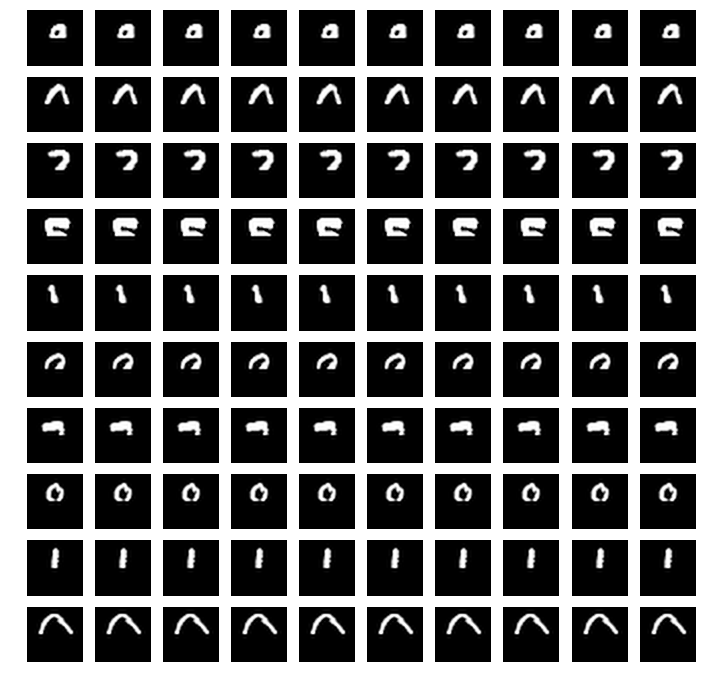

In [101]:
show_completion(cvae_model_d10_a1)

In [ ]:
show_completion(cvae_model_d10_a05)

torch.Size([100, 392]) torch.Size([100, 392]) torch.Size([10, 392])


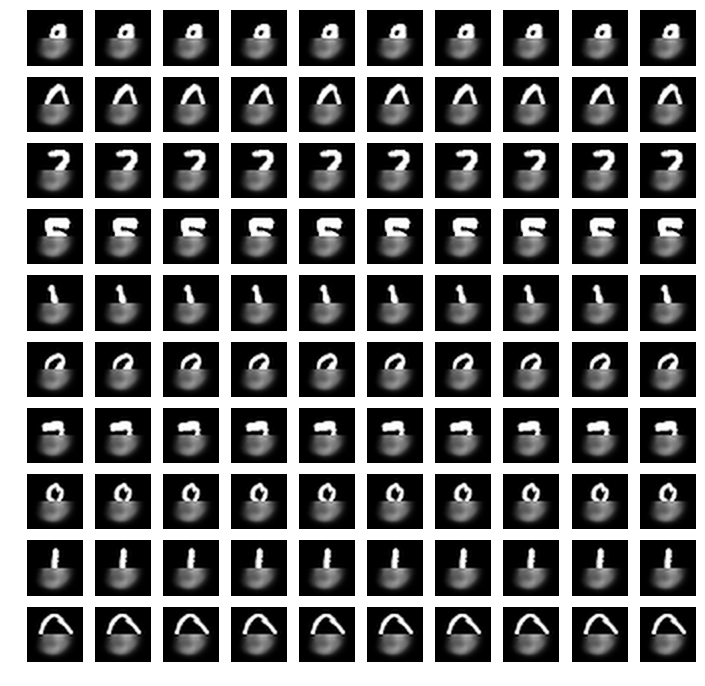

In [70]:
show_completion(cvae_model_d10_a0)

### Оценки логарифма правдоподобия

In [ ]:
for label, name, model in [
    (r'Monte-Carlo, $\alpha=1$', 'MC', cvae_model_d10_a1),
    (r'Importance Sampling, $\alpha=1$', 'IS', cvae_model_d10_a1),
    (r'Monte-Carlo, $\alpha=0.5$', 'MC', cvae_model_d10_a05),
    (r'Importance Sampling, $\alpha=0.5$', 'IS', cvae_model_d10_a05),
    (r'Monte-Carlo, $\alpha=0$', 'MC', cvae_model_d10_a0),
    #(r'Importance Sampling, $\alpha=0$', 'IS', cvae_model_d10_a0),
    # не нужно, поскольку здесь предложная сеть вообще не обучается
]:
    data = [x[name] for x in model['test_results']]
    x_labels = (1 + np.arange(len(data))) / 6
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmax=x_labels[-1])
plt.ylabel('Log-likelihood estimation, 10 samples')
plt.legend()

## Запускаемся на FashionMNIST

In [ ]:
data = FashionMNIST('fashion_mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 256, data.train_labels)
data = FashionMNIST('fashion_mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 256, data.test_labels)

In [ ]:
show_images(Variable(train_data[:10][0]))

In [ ]:
cvae_model_d10_a1 = train_model(CVAE(10, 392, 392, 1), tests=cvae_tests, learning_rate=5e-3)

In [ ]:
show_completion(cvae_model_d10_a1)

Место для ваших выводов.

~

In [98]:
import gc
gc.collect()

12305